In [1]:
#| default_exp io

In [2]:
#| export

import numpy as np
from skimage import transform
from skimage.io import imread, imsave
import h5py
from typing import Iterable
import tifffile
import json
import os
from copy import deepcopy

In [3]:
import matplotlib.pyplot as plt
import mcubes

## Basic I/O

In this notebook, we define a number of functions for image, mesh, and metadata loading and saving, and show how to use the with the data from the ``basics_example`` folder.

## Load and subsample data for segmentation

Let's load the dataset. We then enter the relevant metadata - the filename, resolution in microns, and how much we want to subsample for segmentation purposes.

In [4]:
#| export

def adjust_axis_order(image, channel_axis=None):
    """
    Adjust axis order of image (numpy array) so that the channel axis is axis 0. 
    
    If channel axis is not specified, it is infered as the axis with the smallest number of entries.
    If the image contains a single channel, this function adds a singleton dimension.
    Axis order is otherwise left unchanged. Image must have 3 axes (single channel volumetric)
    or four axes (multichannel volumetric). 
    
    Parameters
    ----------
    image: np.ndarray with 3 or 4 axes
        Input image.
    channel_axis: int or None, optional
        Channel axis
    
    Returns
    -------
    transposed image: np.ndarray with 4 axes
        Input image, channel now axis 0.
    """
    assert 2 < len(image.shape) <5 , "image must have 3 or 4 axes"
    if len(image.shape) == 3:
        return image[np.newaxis]
    if channel_axis is None:
        channel_axis = np.argmin(image.shape)
    return np.moveaxis(image, channel_axis, 0)

In [5]:
metadata_dict = {'filename': 'basics_example/basics_example',
                 'resolution_in_microns': (1, 0.36, 0.36), # you can typically get this from the .tif metadata
                 'subsampling_factors': (1, 1/3, 1/3),
                 'normal_offsets':np.linspace(-2, 2, 5) # normal offsets for map projection, in microns
                }

In [6]:
image = adjust_axis_order(imread(f"{metadata_dict['filename']}.tif"))
print("image shape:", image.shape) # image shape - spatial axes are in z-x-y order

image shape: (2, 26, 454, 511)


In [7]:
subsampled_image = transform.rescale(image, metadata_dict['subsampling_factors'],
                                     channel_axis=0, preserve_range=True)
print("subsampled image shape:", subsampled_image.shape)

subsampled image shape: (2, 26, 151, 170)


## Create 3d segmentation

Now create a 3d segmentation, in this case using ilatik. ilastik works best with input saved as `.h5` data sets. 

In [8]:
#| export

def write_h5(filename, image, h5_dataset_name="image"):
    """Write image (numpy array) as .h5 file (e.g. as input for ilastik)."""
    with h5py.File(filename, "w") as f:
        f.create_dataset('image', data=image)
    return None

def read_h5(filename):
    """Read .h5 file (e.g. ilastik output) into numpy array. Loads alphabetically first entry in .h5."""
    with h5py.File(filename, "r") as f:
        arr = f[sorted(f.keys())[0]][()] 
    return arr

In [9]:
# we now save the subsampled image a .h5 file for input into ilastik for segmentation

write_h5(f"{metadata_dict['filename']}_subsampled.h5", subsampled_image)

In [10]:
# after creating an ilastik project, training the model, and exporting the probabilities, we load the segmentation

segmentation = read_h5(f"{metadata_dict['filename']}_subsampled-image_Probabilities.h5")
segmentation = segmentation[0] # select the first channel of the segmentation - it's the probablity a pixel
                               # is part of the sample
print("segmentation shape:", segmentation.shape)

segmentation shape: (26, 151, 170)


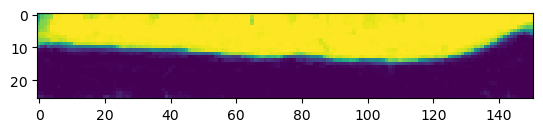

In [11]:
# look at the segmentation in a cross section

plt.imshow(segmentation[:,:,50], vmin=0, vmax=1)

## Meshing

We convert the segmentation into a triangular mesh using the marching cubes method, and save the mesh. We introduce a couple of functions for mesh io and mesh handling. We save all meshes in as wavefront `.obj` files (see [wikipedia](https://en.wikipedia.org/wiki/Wavefront_.obj_file)). In python, we represent missing entries (such as a vertex which doesn't have a normal by `np.nan`.

**Important convention** For sanities sake, we will always store all mesh coordinates in microns. This means rescaling appropriately after calculating the mesh from the 3d segmentation.

For holding and handling `.obj` meshes, we will create a `ObjMesh` class.

In [77]:
#| export

def flatten(lst, max_depth=1000, iter_count=0):
    """
    Flatten a list of lists into a list.

    Also works with inhomogeneous lists, e.g., [[0,1],2]. The argument
    depth determines how "deep" to flatten the list, e.g. with max_depth=1:
    [[(1,0), (1,0)]] -> [(1,0), (1,0)].

    Parameters
    ----------
    lst : list
        list-of-lists.
    max_depth : int, optional
        To what depth to flatten the list.
    iter_count : int, optional
        Helper argument for recursion depth determination.
    
    Returns
    -------
    iterator
        flattened list.
    """
    for el in lst:
        if (isinstance(el, Iterable) and not isinstance(el, (str, bytes))
                and iter_count < max_depth):
            yield from flatten(el, max_depth=max_depth,
                               iter_count=iter_count+1)
        else:
            yield el
            
def pad_list(lst, length=3, fill_value=np.nan):
    """Pad end of list with fill_value if shorter than desired length."""
    return lst + max([0, (length-len(lst))]) * [fill_value,]

def unique(sequence):
    """Create list of unique entries in sequence while preserving order"""
    seen = set()
    return [x for x in sequence if not (x in seen or seen.add(x))]

def index_else_nan(arr, ind):
    """Return arr[ind] if not np.isnan(ind), else npnan*np.ones(arr.shape[1:])"""
    if np.isnan(ind):
        target_shape = arr.shape[1:] if len(arr).shape > 1 else (1,)
        return np.nan*np.ones(target_shape)
    return arr[ind]

In [115]:
#| export

class ObjMesh:
    """
    Simple class for reading, holding, transforming, and saving 3d polygonal meshes in the .obj format.
    See https://en.wikipedia.org/wiki/Wavefront_.obj_file.
    Attributes
        - vertices = [(x_0, y_0, z_0), ... ]
        - texture_vertices = [(u_0, v_0), ...] or None
        - normals = [(nx_0, ny_0, nz_0), ...] or None
        - faces = [f0, ...]
        - only_vertices = bool. 
    vertices, texture_vertices, normals are np.arrays, faces is a list of lists.
    Each face is either a list of vertex indices (if only_vertices is True), or, if the mesh
    has texture and normal information, a list of vertex/texture/normal index triples.
    Missing data is represented by np.nan. Faces can be any length (triangles, quads, ...).
    Indices start at 0!
    
    The method match_vertex_info can be used to match up vertices, texture vertices and
    normals based on the face connectivity. This sets the following attributes:
        - matched_vertices
        - matched_texture_vertices
        - matched_normals
    as np.array's with correspondong rows. 

    The property tris gets all triangles as a numpy array.
    """
    
    def __init__(self, vertices, faces, texture_vertices=None, normals=None, name=None):
        self.vertices, self.faces = (vertices, faces)
        self.texture_vertices, self.normals = (texture_vertices, normals)
        self.name = None
        self.only_vertices = texture_vertices is None and normals is None


    @staticmethod
    def read_obj(filename):
        """
        Return vertices, texture vertices, normals, and faces from an obj file.

        Faces are lists of 3-tuples vertex/texture vertex/normal. If a certain vertex has no texture or normal 
        associated to it, the entry is np.nan, else it is an index into the vertex, texture, and normal arrays
        (note: indices of returned faces start at 0!). See https://en.wikipedia.org/wiki/Wavefront_.obj_file.
        
        Intended for .obj files containing a single object only.

        Parameters
        ----------
        filename : str
            filename
        Returns
        -------
        mesh: ObjMesh
        """
        def _str_to_int_or_nan(x):
            """Convert string to int or np.nan if string is empty"""
            if x == '':
                return np.nan
            return int(x)
        with open(filename, 'r') as f:
            lines = f.readlines()
        names = [ln.split()[1:] for ln in lines if ln.startswith("o ")]
        name = None if len(names) == 0 else names[0]
        vs = np.array([ln.split()[1:] for ln in lines if ln.startswith("v ")]).astype(float)
        vts = np.array([ln.split()[1:] for ln in lines if ln.startswith("vt ")]).astype(float)
        ns = np.array([ln.split()[1:] for ln in lines if ln.startswith("vn ")]).astype(float)
        fs = [ln.split()[1:] for ln in lines if ln.startswith("f ")]
        fs = [[pad_list([_str_to_int_or_nan(y)-1 for y in x.split("/")], length=3, fill_value=np.nan)
               for x in f] for f in fs]
        if vts.shape == (0,) and ns.shape == (0,):
            fs = [[v[0] for v in f] for f in fs]
            mesh = ObjMesh(vs, fs, texture_vertices=None, normals=None, name=name)
        else:
            mesh = ObjMesh(vs, fs, texture_vertices=vts, normals=ns, name=name)
        return mesh
    
    def write_obj(self, filename,):
        """
        Write mesh to .obj format

        Can write texture coordinates and normals if included. 

        Parameters
        ----------
        filename : str
            filename to save to

        Returns
        -------
        None

        """
        def _int_or_nan_to_str(x):
            """Convert int/nan to string. np.nan is converted to empty string"""
            if np.isnan(x):
                return ''
            return str(x)
        namelines = ["o {}\n".format(*self.name)] if self.name is not None else []
        if self.only_vertices:
            vlines = ["v {} {} {}\n".format(*v) for v in self.vertices]
            flines = ["f {} {} {}\n".format(*[int(v+1) for v in fc]) for fc in self.faces]
            with open(filename, 'w') as f:
                f.writelines(namelines)
                f.writelines(vlines)
                f.writelines(flines)
        else:
            assert all([len(v)==3 for v in flatten(self.faces, max_depth=1)]), "each vertex must have 3 indices"
            texture_vertices = [] if self.texture_vertices is None else self.texture_vertices
            normals = [] if self.normals is None else self.normals
            vlines = ["v {} {} {}\n".format(*v) for v in self.vertices]
            vtlines = ["vt {} {}\n".format(*vt) for vt in texture_vertices]
            nlines = ["vn {} {} {}\n".format(*n) for n in normals]
            flines = ["f {} {} {}\n".format(*["{}/{}/{}".format(*[_int_or_nan_to_str(ix+1) for ix in v])
                                              for v in fc]) for fc in self.faces]
            with open(filename, 'w') as f:
                f.writelines(namelines)
                f.writelines(vlines)
                f.writelines(vtlines)
                f.writelines(nlines)
                f.writelines(flines)
        return None
 
    def match_vertex_info(self, require_texture_normals=True):
        """
        Match up 3d vertex coordinates / texture coordinates / normals based on face connectivity.
        
        Sets attributes matched_vertices, matched_texture_vertices, matched_normals.
        
        Parameters
        ----------
        require_texture_normals : bool, default True
            If True, discard vertices for which texture or normal info does not exist. In this
            case, the resulting array will _not_ match the face indices! If False,
            attributes that do not exist for a given vertex, are set to np.nan.
            
        Returns
        -------
        None
        """
        assert not require_texture_normals or not self.only_vertices, "method requires normal/texture information"
        if self.only_vertices:
            unique_v_vt_n_pairs = {v: (np.nan, np.nan) for v in flatten(self.faces)}
        else:
            unique_v_vt_n_pairs = {v[0]: (v[1], v[2]) for v in flatten(self.faces, max_depth=1)}
        print(unique_v_vt_n_pairs)
        matched_vertices = np.copy(self.vertices)
        matched_texture_vertices = np.array([index_else_nan(self.texture_vertices, unique_v_vt_n_pairs[key][0])
                                    for key in range(self.vertices.shape[0])])
        matched_normals = np.array([index_else_nan(self.normals, unique_v_vt_n_pairs[key][1])
                                    for key in range(self.vertices.shape[0])])

        if require_texture_normals:
            mask = ~np.isnan(matched_texture_vertices).any(axis=1) & ~np.isnan(matched_normals).any(axis=1)
            matched_vertices = matched_vertices[mask,:]
            matched_texture_vertices = matched_texture_vertices[mask,:]
            matched_normals = matched_normals[mask,:]            
        self.matched_vertices = matched_vertices
        self.matched_texture_vertices = matched_texture_vertices
        self.matched_normals = matched_normals
        return None
        
    @property
    def tris(self):
        """Get all triangles in mesh as a numpy array."""
        if self.only_vertices:
            return np.array([fc for fc in self.faces if len(fc)==3])
        else:
            return np.array([[v[0] for v in fc] for fc in self.faces if len(fc)==3])
        return None
    
    def apply_affine_to_mesh(self, trafo, update_matched_data=True):
        """
        Apply affine transformation to mesh.
        
        Rotate/shear and translate vertices, rotate/shear and renormalize normals,
        flip faces if transformation determinant is -1.

        Parameters
        ----------
        trafo : np.array of shape (4,4) or (3,3)
            Transformation matrix. If (4,4), it is interpreted as affine transformation.
        update_matched_data : bool, default True
            Update matched data

        Returns
        -------
        newmesh : ObjMesh
            Transformed mesh.

        """
        assert trafo.shape==(3,3) or trafo.shape==(4,4), "Transformation matrix must be 3*3 or 4*4"
        if trafo.shape == (3,3):
            trafo_matrix, trafo_translate = (trafo, np.zeros(3))
        elif trafo.shape == (4,4):
            trafo_matrix, trafo_translate = (trafo[:3,:3], trafo[:3,-1])
        newmesh = deepcopy(self)
        newmesh.vertices = self.vertices@trafo_matrix.T + trafo_translate
        if self.normals is not None:
            normals_transformed = self.normals@trafo_matrix.T
            newmesh.normals = (normals_transformed.T / np.linalg.norm(normals_transformed, axis=-1)).T
        if np.linalg.det(trafo_matrix) < 0:
            newmesh.faces = [fc[::-1] for fc in self.faces]
        if update_matched_data and not self.only_vertices:
            newmesh.match_vertex_info()
        return newmesh

In [116]:
# test this on an example
mesh_fname_ref = "registration_example/Drosophila_reference_preregistered.obj"
mesh_fname_data = "registration_example/Drosophila_CAAX-mCherry_mesh_remeshed.obj"

mesh = ObjMesh.read_obj(mesh_fname_data)

In [118]:
mesh.match_vertex_info(require_texture_normals=False)

{0: (nan, 0), 7394: (nan, 7394), 1: (nan, 1), 8350: (nan, 8350), 48: (nan, 48), 50: (nan, 50), 4: (nan, 4), 7: (nan, 7), 3: (nan, 3), 2: (nan, 2), 5: (nan, 5), 106: (nan, 106), 7395: (nan, 7395), 6: (nan, 6), 7396: (nan, 7396), 9: (nan, 9), 12: (nan, 12), 11: (nan, 11), 8: (nan, 8), 13: (nan, 13), 110: (nan, 110), 16: (nan, 16), 17: (nan, 17), 14: (nan, 14), 120: (nan, 120), 18: (nan, 18), 19: (nan, 19), 20: (nan, 20), 15: (nan, 15), 21: (nan, 21), 117: (nan, 117), 22: (nan, 22), 24: (nan, 24), 27: (nan, 27), 28: (nan, 28), 25: (nan, 25), 23: (nan, 23), 31: (nan, 31), 29: (nan, 29), 30: (nan, 30), 26: (nan, 26), 32: (nan, 32), 33: (nan, 33), 34: (nan, 34), 36: (nan, 36), 7911: (nan, 7911), 128: (nan, 128), 39: (nan, 39), 7398: (nan, 7398), 37: (nan, 37), 35: (nan, 35), 38: (nan, 38), 42: (nan, 42), 8141: (nan, 8141), 44: (nan, 44), 40: (nan, 40), 46: (nan, 46), 132: (nan, 132), 47: (nan, 47), 45: (nan, 45), 43: (nan, 43), 49: (nan, 49), 51: (nan, 51), 41: (nan, 41), 53: (nan, 53), 133:

AttributeError: 'int' object has no attribute 'shape'

In [100]:
mesh.matched_texture_vertices

array([[8.47536e-01, 9.99853e-01],
       [8.43632e-01, 9.99853e-01],
       [8.47536e-01, 9.95948e-01],
       ...,
       [1.80000e-05, 4.04000e-03],
       [3.92300e-03, 1.35000e-04],
       [1.80000e-05, 1.36000e-04]])

In [266]:
# now we create a 3d mesh of using the marching cubes method

level_set = mcubes.smooth(segmentation, method="gaussian") # converts segmentation into level set, with 0=surface
vertices, faces = mcubes.marching_cubes(level_set, 0)

# EXTREMELY IMPORTANT - we now rescale the vertex coordinates so that they are in microns.
vertices_in_microns = vertices * (np.array(metadata_dict['resolution_in_microns'])
                                 /np.array(metadata_dict['subsampling_factors']))

In [267]:
mesh = ObjMesh(vertices_in_microns, faces)
mesh.name = "basics_example_mesh_marching_cubes"
mesh.write_obj(f"{metadata_dict['filename']}_mesh_marching_cubes.obj")

In [268]:
mesh.only_vertices

True

In [269]:
%%timeit
mesh.write_obj(f"{metadata_dict['filename']}_mesh_marching_cubes.obj")

262 ms ± 1.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [270]:
%%timeit
ObjMesh.read_obj(f"{metadata_dict['filename']}_mesh_marching_cubes.obj")

170 ms ± 1.51 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [274]:
%%time
## try a somewhat larger mesh with texture info etc

mesh = ObjMesh.read_obj("registration_example/Drosophila_reference.obj")

CPU times: user 863 ms, sys: 43.9 ms, total: 907 ms
Wall time: 905 ms


In [276]:
%%time

mesh.write_obj("registration_example/Drosophila_reference_test_write.obj")

CPU times: user 1.1 s, sys: 23.9 ms, total: 1.12 s
Wall time: 1.12 s


### Saving the results

We can now save the cartographic projections both as `.tif` stack for quantitative analysis, and as `.png`'s for visualization as mesh texture in blender. We will also save the metadata to a `.json` file

Annoyingly, we have to normalize our data and convert it to 8-bit to save it as png.

In [ ]:
#| export

def save_dict_to_json(filename, dictionary):
    """
    Save dictionary to .json file.
    
    Will automatically convert numpy arrays to lists for saving. If you get an error like "XXX is not JSON
    serializable", you need to ensure all your dictionary items are things that can be saved to text by json
    (strings, numbers, lists).
    
    Parameters
    ----------
    filename : str
        Filename to save to
    dictionary : dict
        Dictionary to save
    
    Returns
    -------
    None
    """
    serializable_dictionary = {key: val.tolist() if isinstance(val, np.ndarray) else val
                               for key, val in dictionary.items()}
    with open(filename, "w") as f:
        json.dump(serializable_dictionary, f)
    return None

In [ ]:
# save metadata
save_dict_to_json(f"{metadata_dict['filename']}_metadata.json", metadata_dict)

In [ ]:
#| export

def save_for_imageJ(filename, image, z_axis=None, channel_axis=None):
    """
    Save image as 32bit ImageJ compatible .tif file
    
    If channel_axis is not provided, it is inferred as the shortest axis.
    If z-axis is provided for a 4d array, it will be set as the default z-axis for ImageJ.
    """
    channel_axis = np.argmin(image.shape) if channel_axis is None else channel_axis
    if len(image.shape) == 3:
        transposed_image = np.moveaxis(image, channel_axis, 0)
        tifffile.imwrite(filename, transposed_image.astype(np.float32),
                         metadata={'axes': 'CYX'}, imagej=True,)
    elif len(image.shape) == 4:
        if z_axis is not None:
            transposed_image = np.moveaxis(image, (z_axis, channel_axis), (0,1))
        else:
            transposed_image = np.moveaxis(image, channel_axis, 1)
        tifffile.imwrite(filename, transposed_image.astype(np.float32),
                         metadata={'axes': 'ZCYX'}, imagej=True,)
    return None
    
def normalize_quantiles_for_png(image, quantiles=(0.01, 0.99)):
    """
    Normalize an image by setting given quantiles to 0 and 255 and converting to 8-bit, for saving as .png
    
    Also replaces nan by 0.
    
    Parameters
    ----------
    image : np.array
        Image (should be single-channel)
    quantiles : tuple
        Image quantile to set to 0 and 255.
    
    Returns
    -------
    image_normalized : np.array
        Normalized image, datatype np.uint8
    """
    image_normalized = image - np.nanquantile(image, quantiles[0])
    image_normalized /= np.nanquantile(image_normalized, quantiles[1])
    image_normalized = np.nan_to_num(np.round(np.clip(255*image_normalized, 0, 255)), nan=0)
    return image_normalized.astype(np.uint8)
    
    
def save_stack_for_blender(image, directory, normalization=(0.01, 0.99)):
    """
    Save multichannel volumetric image as series of grayscale .png images. Can normalize data if desired.
    
    This function necessarily converts the image to 8bit. Use a suitable normalization to ensure nothing 
    is lost.
    
    Parameters
    ----------
    image : 4d np.array
        Axis 0 is assumed to be the channel axis, axis 1 is the slicing axes, i.e. images will correspond to
        slices along axis 1.
    directory : str
        Path to save data to. Will create directory if it doesn't exist
    normalization : tuple of float, or callable
        Whether to normalize the image before saving it. If None, no normalization is performed. If a
        tuple is given, it will be interpreted as quantiles to set to 0 and 255, respectively (over the
        whole channel, not each slice). If a callable is provided, it will be applied to each channel.
        
    Returns
    -------
    None
    
    """
    directory = directory.removesuffix('/')
    if not os.path.exists(directory):
        os.makedirs(directory)
    for ic, ch in enumerate(image):
        if callable(normalization):
            ch_normalized = normalization(ch)
        if isinstance(normalization, tuple):
            ch_normalized = normalize_quantiles_for_png(ch, quantiles=normalization)
        for islc, slc in enumerate(ch_normalized):
            slc = np.stack(3*[slc], axis=-1).astype(np.uint8) # necessary for saving as png
            imsave(f'{directory}/channel_{ic}_slice_{str(islc).zfill(3)}.png', slc, check_contrast=False)
    return None

In [ ]:
# read the data so we can check the saving function
projected_data = adjust_axis_order(imread(f"{metadata_dict['filename']}_projected.tif"))
print("Image shape", projected_data.shape)

Image shape (2, 5, 256, 256)


In [ ]:
save_for_imageJ(f"{metadata_dict['filename']}_projected.tif", projected_data, z_axis=1)

In [ ]:
texture_path = f"{os.getcwd()}/{metadata_dict['filename']}_textures"
save_stack_for_blender(projected_data, texture_path, normalization=(0.01, 0.99))